C:\Users\Jason Ng\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Train R^2:  0.7789667788358388
Test  R^2:  0.5933736676584871


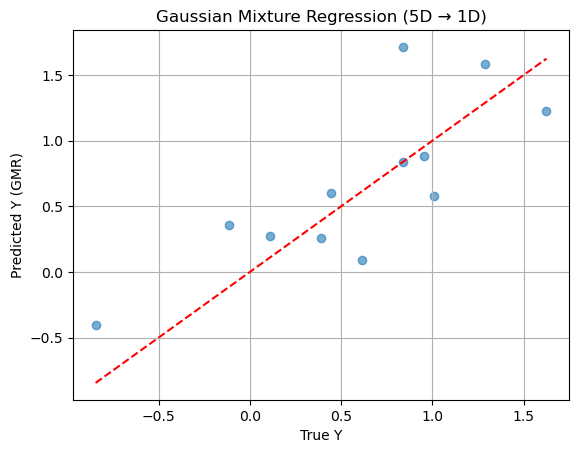

In [10]:
OMP_NUM_THREADS=1
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

root = "tensile_fatigue_data_v14.xlsx"
main_df = pd.read_excel(root)

X = pd.read_excel(root,usecols=[0,1,2,3,4])
y = pd.read_excel(root,usecols=[6])

# Normalize inputs
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size= 0.2, random_state = 10)

# Stack inputs and output for joint modeling
XY = np.hstack([X_train, y_train.reshape(-1, 1)])  # shape (n_samples, 6)

# Fit a Gaussian Mixture Model to the joint distribution
n_components = 6
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(XY)

def gmr_multivariate(gmm, X_query):
    """
    Perform Gaussian Mixture Regression with multivariate X and scalar Y.
    :param gmm: Trained GaussianMixture model (on joint [X, Y])
    :param X_query: Input queries of shape (n_queries, n_features)
    :return: Predicted Y values (mean), shape (n_queries,)
    """
    n_queries = X_query.shape[0]
    n_features = X_query.shape[1]
    y_preds = np.zeros(n_queries)

    for i in range(n_queries):
        x = X_query[i].reshape(-1, 1)  # shape (n_features, 1)

        weights = []
        means = []

        for k in range(gmm.n_components):
            mu = gmm.means_[k].reshape(-1, 1)          # shape (6, 1)
            Sigma = gmm.covariances_[k]                # shape (6, 6)

            mu_x = mu[:n_features]
            mu_y = mu[n_features:]
            Sigma_xx = Sigma[:n_features, :n_features]
            Sigma_xy = Sigma[:n_features, n_features:]
            Sigma_yx = Sigma[n_features:, :n_features]
            Sigma_yy = Sigma[n_features:, n_features:]

            # Compute conditional mean E[Y | X=x]
            inv_Sigma_xx = np.linalg.inv(Sigma_xx)
            cond_mean = mu_y + Sigma_yx @ inv_Sigma_xx @ (x - mu_x)  # shape (1, 1)
            means.append(cond_mean.flatten())

            # Compute responsibility (weight) for component k
            diff = x.flatten() - mu_x.flatten()
            exponent = -0.5 * diff @ inv_Sigma_xx @ diff
            norm_const = np.sqrt((2 * np.pi) ** n_features * np.linalg.det(Sigma_xx))
            prob = np.exp(exponent) / norm_const
            weights.append(gmm.weights_[k] * prob)

        weights = np.array(weights)
        weights /= np.sum(weights)
        means = np.array(means).flatten()
        y_preds[i] = np.sum(weights * means)

    return y_preds

# Query on test inputs
y_train_pred = gmr_multivariate(gmm, X_train)
y_test_pred = gmr_multivariate(gmm, X_test)

var_train = r2_score(y_train, y_train_pred)
var_test  = r2_score(y_test, y_test_pred)

print("Train R^2: ", var_train)
print("Test  R^2: ", var_test)

# Plot prediction vs true (if available)
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Y")
plt.ylabel("Predicted Y (GMR)")
plt.title("Gaussian Mixture Regression (5D → 1D)")
plt.grid(True)
plt.show()


In [5]:
def gmr_multivariate(gmm, X_query):
    """
    Perform Gaussian Mixture Regression with multivariate X and scalar Y.
    :param gmm: Trained GaussianMixture model (on joint [X, Y])
    :param X_query: Input queries of shape (n_queries, n_features)
    :return: Predicted Y values (mean), shape (n_queries,)
    """
    n_queries = X_query.shape[0]
    n_features = X_query.shape[1]
    y_preds = np.zeros(n_queries)

    for i in range(n_queries):
        x = X_query[i].reshape(-1, 1)  # shape (n_features, 1)

        weights = []
        means = []

        for k in range(gmm.n_components):
            mu = gmm.means_[k].reshape(-1, 1)          # shape (6, 1)
            Sigma = gmm.covariances_[k]                # shape (6, 6)

            mu_x = mu[:n_features]
            mu_y = mu[n_features:]
            Sigma_xx = Sigma[:n_features, :n_features]
            Sigma_xy = Sigma[:n_features, n_features:]
            Sigma_yx = Sigma[n_features:, :n_features]
            Sigma_yy = Sigma[n_features:, n_features:]

            # Compute conditional mean E[Y | X=x]
            inv_Sigma_xx = np.linalg.inv(Sigma_xx)
            cond_mean = mu_y + Sigma_yx @ inv_Sigma_xx @ (x - mu_x)  # shape (1, 1)
            means.append(cond_mean.flatten())

            # Compute responsibility (weight) for component k
            diff = x.flatten() - mu_x.flatten()
            exponent = -0.5 * diff @ inv_Sigma_xx @ diff
            norm_const = np.sqrt((2 * np.pi) ** n_features * np.linalg.det(Sigma_xx))
            prob = np.exp(exponent) / norm_const
            weights.append(gmm.weights_[k] * prob)

        weights = np.array(weights)
        weights /= np.sum(weights)
        means = np.array(means).flatten()
        y_preds[i] = np.sum(weights * means)

    return y_preds

In [8]:
def gmr_multivariate(gmm, X_query):
    """
    Perform Gaussian Mixture Regression with multivariate X and scalar Y.
    :param gmm: Trained GaussianMixture model (on joint [X, Y])
    :param X_query: Input queries of shape (n_queries, n_features)
    :return: Predicted Y values (mean), shape (n_queries,)
    """
    n_queries = X_query.shape[0]
    n_features = X_query.shape[1]
    y_preds = np.zeros(n_queries)

    for i in range(n_queries):
        x = X_query[i].reshape(-1, 1)  # shape (n_features, 1)

        weights = []
        means = []

        for k in range(gmm.n_components):
            mu = gmm.means_[k].reshape(-1, 1)          # shape (6, 1)
            Sigma = gmm.covariances_[k]                # shape (6, 6)

            mu_x = mu[:n_features]
            mu_y = mu[n_features:]
            Sigma_xx = Sigma[:n_features, :n_features]
            Sigma_xy = Sigma[:n_features, n_features:]
            Sigma_yx = Sigma[n_features:, :n_features]
            Sigma_yy = Sigma[n_features:, n_features:]

            # Compute conditional mean E[Y | X=x]
            inv_Sigma_xx = np.linalg.inv(Sigma_xx)
            cond_mean = mu_y + Sigma_yx @ inv_Sigma_xx @ (x - mu_x)  # shape (1, 1)
            means.append(cond_mean.flatten())

            # Compute responsibility (weight) for component k
            diff = x.flatten() - mu_x.flatten()
            exponent = -0.5 * diff @ inv_Sigma_xx @ diff
            norm_const = np.sqrt((2 * np.pi) ** n_features * np.linalg.det(Sigma_xx))
            prob = np.exp(exponent) / norm_const
            weights.append(gmm.weights_[k] * prob)

        weights = np.array(weights)
        weights /= np.sum(weights)
        means = np.array(means).flatten()
        y_preds[i] = np.sum(weights * means)

    return y_preds

def GMM_NN(variable):

    # 1. Prepare the data
    df_x = pd.read_excel(root,usecols=[0,1,2,3,4])
    df_y = pd.read_excel(root,usecols=[variable])
    
    X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state = 42)

    # Stack inputs and output for joint modeling
    XY = np.hstack([X_train, y_train])  # shape (n_samples, 6)
    
    # Fit a Gaussian Mixture Model to the joint distribution
    n_components = 6
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state = 42)
    gmm.fit(XY)

    gmm_train_pred = gmr_multivariate(gmm, X_train)
    gmm_test_pred = gmr_multivariate(gmm, X_test)
    
    # Combine the original features and the GBR predictions as new inputs for the Neural Network
    X_train_nn = np.hstack([X_train, gmm_train_pred.reshape(-1, 1)])
    X_test_nn = np.hstack([X_test, gmm_test_pred.reshape(-1, 1)])
    
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_nn, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    
    # 3. Define a simple neural network in PyTorch
    class RegressionNN(nn.Module):
        def __init__(self, input_size):
            super(RegressionNN, self).__init__()
            self.fc1 = nn.Linear(input_size, 64)
            self.fc2 = nn.Linear(64, 128)
            self.fc3 = nn.Linear(128, 256)
            self.fc4 = nn.Linear(256, 128)
            self.fc5 = nn.Linear(128, 64)
            self.fc6 = nn.Linear(64, 1)
       
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = torch.relu(self.fc3(x))
            x = torch.relu(self.fc4(x))
            x = torch.relu(self.fc5(x))
            x = self.fc6(x)
            return x
    
    # Create the neural network
    input_size = X_train_nn.shape[1]
    model = RegressionNN(input_size)
    
    # 4. Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Regularization parameters
    lambda_l1 = 0   # L1 penalty strength
    lambda_l2 = 1e-4   # L2 penalty strength

    # L2 can also be directly included in the optimizer as weight_decay
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=lambda_l2)
    
    plt.ion()
    
    # 5. Train the Neural Network
    n_epochs = 1000 # Default 1000
    for epoch in range(n_epochs):
        model.train()
       
        # Forward pass
        y_train_pred = model(X_train_tensor)
        y_test_pred  = model(X_test_tensor)
        loss = criterion(y_train_pred, y_train_tensor)
        
        #Note: L2 Regularization already handled in optimizer via weight_decay

        # Add L1 Regularization
        l1_norm = sum(param.abs().sum() for param in model.parameters())
        loss += lambda_l1 * l1_norm
       
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Obtaining R2 scores for train and test datasets
        var_train = r2_score(y_train_tensor.data.numpy(), y_train_pred.detach().numpy())
        var_test  = r2_score(y_test_tensor.data.numpy(), y_test_pred.detach().numpy())

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')
            print("Train R^2: ", var_train)
            print("Test  R^2: ", var_test)

            fig, axes = plt.subplots(2, 2, figsize = (7,5))
            axes[0, 0].scatter(y_train_tensor, y_train_pred.detach().numpy())
            axes[0, 0].plot([min(y_train_tensor.data.numpy()), max(y_train_tensor.data.numpy())],[min(y_train_tensor.data.numpy()), max(y_train_tensor.data.numpy())], color = 'r')
            axes[0, 0].set_title("Training Data")
            axes[0, 0].set_xlabel("Actual values")
            axes[0, 0].set_ylabel("Predicted values")
    
            axes[0, 1].scatter(y_test_tensor, y_test_pred.detach().numpy())
            axes[0, 1].plot([min(y_test_tensor.data.numpy()), max(y_test_tensor.data.numpy())],[min(y_test_tensor.data.numpy()), max(y_test_tensor.data.numpy())], color = 'r')
            axes[0, 1].set_title("Test Data")
            axes[0, 1].set_xlabel("Actual values")
            axes[0, 1].set_ylabel("Predicted values")
    
            axes[1, 0].plot(y_train_tensor.data.numpy().squeeze()*10,'tab:orange', label = 'real')
            axes[1, 0].plot(y_train_pred.detach().numpy()*10,'tab:green',label = 'pred')
            axes[1, 0].set_xlabel("Sample Number")
            axes[1, 0].set_ylabel("Fatigue Constant Value")
            axes[1, 0].legend()
    
            axes[1, 1].plot(y_test_tensor.data.numpy().squeeze()*10, 'tab:orange',label = 'real')
            axes[1, 1].plot(y_test_pred.detach().numpy()*10,'tab:green',label = 'pred')
            axes[1, 1].set_xlabel("Sample Number")
            axes[1, 1].set_ylabel("Fatigue Constant Value")
            axes[1, 1].legend()

            plt.tight_layout()

            # # Scatter plot - Train
            # min_train, max_train = y_train_tensor.min().item(), y_train_tensor.max().item()
            # axes[0, 0].scatter(y_train_tensor, y_train_pred.detach().numpy())
            # axes[0, 0].plot([min_train, max_train], [min_train, max_train], 'r')
            # axes[0, 0].set_title("Training Data")
            # axes[0, 0].set_xlabel("Actual values")
            # axes[0, 0].set_ylabel("Predicted values")
            
            # # Scatter plot - Test
            # min_test, max_test = y_test_tensor.min().item(), y_test_tensor.max().item()
            # axes[0, 1].scatter(y_test_tensor, y_test_pred.detach().numpy())
            # axes[0, 1].plot([min_test, max_test], [min_test, max_test], 'r')
            # axes[0, 1].set_title("Test Data")
            # axes[0, 1].set_xlabel("Actual values")
            # axes[0, 1].set_ylabel("Predicted values")
            
            # # Line plot - Train
            # axes[1, 0].plot(y_train_tensor.numpy().squeeze() * 10, 'tab:orange', label='real')
            # axes[1, 0].plot(y_train_pred.detach().numpy() * 10, 'tab:green', label='pred')
            # axes[1, 0].set_xlabel("Sample Number")
            # axes[1, 0].set_ylabel("Fatigue Constant Value")
            # axes[1, 0].legend()
            
            # # Line plot - Test
            # axes[1, 1].plot(y_test_tensor.numpy().squeeze() * 10, 'tab:orange', label='real')
            # axes[1, 1].plot(y_test_pred.detach().numpy() * 10, 'tab:green', label='pred')
            # axes[1, 1].set_xlabel("Sample Number")
            # axes[1, 1].set_ylabel("Fatigue Constant Value")
            # axes[1, 1].legend()
            # plt.tight_layout()
            
            plt.show()
    
            plt.draw();plt.pause(0.05)
    
    plt.ioff()
    plt.show()
    
    # 6. Evaluate the model on the test data
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        test_loss = mean_squared_error(y_test_tensor.numpy(), test_predictions.numpy())
        print(f'Test MSE: {test_loss:.4f}')

In [23]:
OMP_NUM_THREADS=1
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

root = "tensile_fatigue_data_v14.xlsx"
main_df = pd.read_excel(root)

X = pd.read_excel(root,usecols=[0,1,2,3,4])
y = pd.read_excel(root,usecols=[6])

# Normalize inputs
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size= 0.2, random_state = 10)

# Stack inputs and output for joint modeling
XY = np.hstack([X_train, y_train.reshape(-1, 1)])  # shape (n_samples, 6)

# Fit a Gaussian Mixture Model to the joint distribution
n_components = 6
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(XY)

def gmr_multivariate(gmm, X_query):
    """
    Perform Gaussian Mixture Regression with multivariate X and scalar Y.
    :param gmm: Trained GaussianMixture model (on joint [X, Y])
    :param X_query: Input queries of shape (n_queries, n_features)
    :return: Predicted Y values (mean), shape (n_queries,)
    """
    n_queries = X_query.shape[0]
    n_features = X_query.shape[1]
    y_preds = np.zeros(n_queries)

    for i in range(n_queries):
        x = X_query[i].reshape(-1, 1)  # shape (n_features, 1)

        weights = []
        means = []

        for k in range(gmm.n_components):
            mu = gmm.means_[k].reshape(-1, 1)          # shape (6, 1)
            Sigma = gmm.covariances_[k]                # shape (6, 6)

            mu_x = mu[:n_features]
            mu_y = mu[n_features:]
            Sigma_xx = Sigma[:n_features, :n_features]
            Sigma_xy = Sigma[:n_features, n_features:]
            Sigma_yx = Sigma[n_features:, :n_features]
            Sigma_yy = Sigma[n_features:, n_features:]

            # Compute conditional mean E[Y | X=x]
            inv_Sigma_xx = np.linalg.inv(Sigma_xx)
            cond_mean = mu_y + Sigma_yx @ inv_Sigma_xx @ (x - mu_x)  # shape (1, 1)
            means.append(cond_mean.flatten())

            # Compute responsibility (weight) for component k
            diff = x.flatten() - mu_x.flatten()
            exponent = -0.5 * diff @ inv_Sigma_xx @ diff
            norm_const = np.sqrt((2 * np.pi) ** n_features * np.linalg.det(Sigma_xx))
            prob = np.exp(exponent) / norm_const
            weights.append(gmm.weights_[k] * prob)

        weights = np.array(weights)
        weights /= np.sum(weights)
        means = np.array(means).flatten()
        y_preds[i] = np.sum(weights * means)

    return y_preds

# Query on test inputs
gmm_train_pred = gmr_multivariate(gmm, X_train)
gmm_test_pred = gmr_multivariate(gmm, X_test)

var_train = r2_score(y_train, gmm_train_pred)
var_test  = r2_score(y_test, gmm_test_pred)

print("Train R^2: ", var_train)
print("Test  R^2: ", var_test)

gmm_train_pred = gmr_multivariate(gmm, X_train)
gmm_test_pred = gmr_multivariate(gmm, X_test)

# Combine the original features and the GBR predictions as new inputs for the Neural Network
X_train_nn = np.hstack([X_train, gmm_train_pred.reshape(-1, 1)])
X_test_nn = np.hstack([X_test, gmm_test_pred.reshape(-1, 1)])

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_nn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 3. Define a simple neural network in PyTorch
class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 1)
   
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# Create the neural network
input_size = X_train_nn.shape[1]
model = RegressionNN(input_size)

# 4. Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Regularization parameters
lambda_l1 = 0   # L1 penalty strength
lambda_l2 = 1e-4   # L2 penalty strength

# L2 can also be directly included in the optimizer as weight_decay
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=lambda_l2)

plt.ion()

# 5. Train the Neural Network
n_epochs = 1000 # Default 1000
for epoch in range(n_epochs):
    model.train()
   
    # Forward pass
    y_train_pred = model(X_train_tensor)
    y_test_pred  = model(X_test_tensor)
    loss = criterion(y_train_pred, y_train_tensor)
    
    #Note: L2 Regularization already handled in optimizer via weight_decay

    # Add L1 Regularization
    l1_norm = sum(param.abs().sum() for param in model.parameters())
    loss += lambda_l1 * l1_norm
   
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(y_train_tensor)
    print(y_train_pred)
    
    # Obtaining R2 scores for train and test datasets
    var_train = r2_score(y_train_tensor.data.numpy(), y_train_pred.detach().numpy())
    var_test  = r2_score(y_test_tensor.data.numpy(), y_test_pred.detach().numpy())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')
        print("Train R^2: ", var_train)
        print("Test  R^2: ", var_test)

        fig, axes = plt.subplots(2, 2, figsize = (7,5))
        axes[0, 0].scatter(y_train_tensor, y_train_pred.detach().numpy())
        axes[0, 0].plot([min(y_train_tensor.data.numpy()), max(y_train_tensor.data.numpy())],[min(y_train_tensor.data.numpy()), max(y_train_tensor.data.numpy())], color = 'r')
        axes[0, 0].set_title("Training Data")
        axes[0, 0].set_xlabel("Actual values")
        axes[0, 0].set_ylabel("Predicted values")

        axes[0, 1].scatter(y_test_tensor, y_test_pred.detach().numpy())
        axes[0, 1].plot([min(y_test_tensor.data.numpy()), max(y_test_tensor.data.numpy())],[min(y_test_tensor.data.numpy()), max(y_test_tensor.data.numpy())], color = 'r')
        axes[0, 1].set_title("Test Data")
        axes[0, 1].set_xlabel("Actual values")
        axes[0, 1].set_ylabel("Predicted values")

        axes[1, 0].plot(y_train_tensor.data.numpy().squeeze()*10,'tab:orange', label = 'real')
        axes[1, 0].plot(y_train_pred.detach().numpy()*10,'tab:green',label = 'pred')
        axes[1, 0].set_xlabel("Sample Number")
        axes[1, 0].set_ylabel("Fatigue Constant Value")
        axes[1, 0].legend()

        axes[1, 1].plot(y_test_tensor.data.numpy().squeeze()*10, 'tab:orange',label = 'real')
        axes[1, 1].plot(y_test_pred.detach().numpy()*10,'tab:green',label = 'pred')
        axes[1, 1].set_xlabel("Sample Number")
        axes[1, 1].set_ylabel("Fatigue Constant Value")
        axes[1, 1].legend()

        plt.tight_layout()
        
        plt.show()

        plt.draw();plt.pause(0.05)

plt.ioff()
plt.show()

C:\Users\Jason Ng\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Train R^2:  0.7789667788358388
Test  R^2:  0.5933736676584871
tensor([[-7.8849e-01],
        [ 4.4615e-01],
        [-2.6405e+00],
        [-5.0789e-01],
        [-1.7117e-01],
        [-2.2729e-01],
        [-1.1505e-01],
        [ 7.2676e-01],
        [-3.9565e-01],
        [ 1.7369e+00],
        [ 6.7064e-01],
        [-1.0691e+00],
        [-7.8849e-01],
        [-1.7986e+00],
        [-2.9211e+00],
        [ 1.0074e+00],
        [-1.1505e-01],
        [ 7.8288e-01],
        [ 4.4615e-01],
        [ 1.0074e+00],
        [ 4.4615e-01],
        [-5.6401e-01],
        [-1.7986e+00],
        [-5.0789e-01],
        [-5.8926e-02],
        [ 7.2676e-01],
        [ 1.0074e+00],
        [ 1.1757e+00],
        [-1.7117e-01],
        [ 3.3391e-01],
        [-4.5177e-01],
        [ 3.3391e-01],
        [ 3.9003e-01],
        [-1.1505e-01],
        [-1.0691e+00],
        [-2.8060e-03],
        [ 2.7779e-01],
        [-4.5177e-01],
        [ 4.4615e-01],
        [ 9.5124e-01],
        [-1.7986e+

ValueError: Found array with dim 3. None expected <= 2.

In [6]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ---- Generate data ----
root = "tensile_fatigue_data_v14.xlsx"
main_df = pd.read_excel(root)

X = pd.read_excel(root,usecols=[0,1,2,3,4])
Y = pd.read_excel(root,usecols=[6])

# Combine for GMM fitting
XY = np.hstack([X, Y.ravel()])

# ---- GMM Regression Setup ----
def gmr_predict(gmm, X_query):
    n_queries = X_query.shape[0]
    n_features = X_query.shape[1]
    y_preds = np.zeros(n_queries)

    for i in range(n_queries):
        x = X_query[i].reshape(-1, 1)
        weights = []
        means = []

        for k in range(gmm.n_components):
            mu = gmm.means_[k].reshape(-1, 1)
            Sigma = gmm.covariances_[k]

            mu_x = mu[:n_features]
            mu_y = mu[n_features:]
            Sigma_xx = Sigma[:n_features, :n_features]
            Sigma_yx = Sigma[n_features:, :n_features]

            inv_Sigma_xx = np.linalg.inv(Sigma_xx)
            cond_mean = mu_y + Sigma_yx @ inv_Sigma_xx @ (x - mu_x)
            means.append(cond_mean.flatten())

            diff = x.flatten() - mu_x.flatten()
            exponent = -0.5 * diff @ inv_Sigma_xx @ diff
            norm_const = np.sqrt((2 * np.pi) ** n_features * np.linalg.det(Sigma_xx))
            prob = np.exp(exponent) / norm_const
            weights.append(gmm.weights_[k] * prob)

        weights = np.array(weights)
        weights /= np.sum(weights)
        means = np.array(means).flatten()
        y_preds[i] = np.sum(weights * means)

    return y_preds

# Fit GMM on [X, Y]
gmm = GaussianMixture(n_components=6, covariance_type='full', random_state=42)
gmm.fit(XY)

# ---- Get GMM predictions and augment features ----
y_gmm = gmr_predict(gmm, X).reshape(-1, 1)
X_aug = np.hstack([X, y_gmm])  # 5 original + 1 GMM feature

# ---- Train-test split ----
X_train, X_test, y_train, y_test = train_test_split(X_aug, Y, test_size=0.2, random_state=42)

# ---- DNN Model ----
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

# ---- Training ----
model = DNNModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 300
for epoch in range(n_epochs):
    model.train()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

# ---- Evaluation ----
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy().flatten()

rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"\nTest RMSE: {rmse:.4f}")

# ---- Plot predictions ----
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Y")
plt.ylabel("Predicted Y (Hybrid GMM+DNN)")
plt.title("Prediction vs Ground Truth")
plt.grid(True)
plt.show()


AttributeError: 'DataFrame' object has no attribute 'ravel'